<a href="https://colab.research.google.com/github/Erasnilson/Analise-fraude-Ensemble-Voting/blob/main/Analise_Fraude_Voting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análise de detecção de fraude via Ensemble Voting

Em síntes, a tecnica Voting combina as previsões de vários modelos individuais para melhorar a performance geral do modelo. Assim, ao combinar diferentes modelos, os erros individuais de cada modelo podem ser compensados, resultando em uma previsão mais robusta e precisa.

A seguir utilizaremos o conjunto de dados disponível no Kaggle para exemplificar as técnicas de classificação aplicadas à análise de fraudes em cartões de crédito.(https://www.kaggle.com/code/renjithmadhavan/credit-card-fraud-detection-using-python/input)

# Tipos de Voting:

- **Majority Voting (Hard Voting)**: cada modelo individual (ou estimador) faz uma previsão de classe, e a classe final é determinada por voto majoritário. A classe que recebe mais votos entre os modelos é a previsão final.
Exemplo: Se três modelos com previsões (fitted) para as classes [1, 0, 1], a classe final será 1, pois a maioria dos modelos votou por essa classe.

- **Averaging (Soft Voting)**: No Soft Voting, em vez de prever diretamente as classes, cada modelo fornece uma probabilidade de cada classe. As probabilidades são então somadas (ou calculadas a média), e a classe com a maior probabilidade média é escolhida como a previsão final.

Exemplo: ao considerar três modelos com as seguintes probabilidades para a classe 1: [0.5, 0.4, 0.9], a probabilidade média para a classe 1 seria 0.6, e essa seria a previsão final.

Vantagens do Ensemble Voting:

- **Redução de Variância**: Ao combinar vários modelos, o ensemble pode reduzir a variância de um único modelo, tornando-o menos propenso a overfitting.

- **Melhoria na Precisão**: Como diferentes modelos podem capturar diferentes padrões nos dados, o ensemble tende a melhorar a precisão das previsões.

- **Flexibilidade**: É possível combinar diferentes tipos de modelos (e.g., árvores de decisão, redes neurais, regressão logística), tornando o ensemble uma abordagem flexível.


In [1]:
import numpy as np
import pandas as pd               # manipulação de data frames no python
import matplotlib.pyplot as plt   # plots/gráficos
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [4]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 99% 65.0M/66.0M [00:01<00:00, 47.8MB/s]
100% 66.0M/66.0M [00:01<00:00, 49.8MB/s]


In [5]:
import zipfile

# Define the path to your zip file
file_path = '/content/creditcardfraud.zip'  # Replace 'your_file.zip' with your file's name


In [6]:
# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content')  # Replace 'destination_folder' with your desired folder

In [7]:
df = pd.read_csv('/content/creditcard.csv')
print(df.shape)
df.head()


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
#df.info()

## Síntes dos dados



In [9]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [10]:
# A variável class denota o presença e ausência de fraude
class_names = {0:'Not Fraud', 1:'Fraud'}
print(df.Class.value_counts().rename(index = class_names))

Class
Not Fraud    284315
Fraud           492
Name: count, dtype: int64


## Modelagem de Classificação
Amostragem do conjunto de dados em:
- 70% Treino
- 30% Teste

In [11]:
# import dos datasets ja existentes no scikit-learn (iris)
from sklearn import datasets

# import das classes dos algoritmos de classificação
from sklearn.tree import DecisionTreeClassifier     # Arvore de decisao
from sklearn.neural_network import MLPClassifier    # MLP
from sklearn.neighbors import KNeighborsClassifier  # k-NN

# import das classes dos algoritmos de ensemble
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier

# import das metodologias de experientação
from sklearn.model_selection import train_test_split # holdout
from sklearn.metrics import accuracy_score           # acurácia

In [12]:
feature_names = df.iloc[:, 1:30].columns
target = df.iloc[:1, 30: ].columns
print(feature_names) # Coveriáveis X
print(target) # Va Resposta Y

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')
Index(['Class'], dtype='object')


In [13]:
data_features = df[feature_names]
data_target = df[target]

In [14]:
# seed para reprodução dos experimentos
seed = 10

In [15]:
# Separar os conjuntos de treino e teste
# - usaremos holdout
# - 2/3 dos exemplos compõem o conjunto de treinamento
# - 1/3 dos exemplos compõem o conjunto de teste
# a amostragem é estratificada (stratify)

[X_train, X_test, y_train, y_test] = train_test_split(data_features, data_target, test_size=0.30, stratify=data_target, random_state=seed)
print("*** Dimensões dos conjuntos de dados ***")
print("- (X_train) Conjunto de treinamento:\t\t", X_train.shape)
print("- (y_train) Rótulos do conjunto de treinamento:\t", y_train.shape)
print("- (X_test) Conjunto de teste:\t\t\t", X_test.shape)
print("- (y_test) Rótulos do conjunto de teste:\t",y_test.shape)

*** Dimensões dos conjuntos de dados ***
- (X_train) Conjunto de treinamento:		 (199364, 29)
- (y_train) Rótulos do conjunto de treinamento:	 (199364, 1)
- (X_test) Conjunto de teste:			 (85443, 29)
- (y_test) Rótulos do conjunto de teste:	 (85443, 1)


In [17]:
# Convertendo os conjuntos de dados do formato do pandas para numpy array
y_train_values = y_train.values.ravel().astype(int)
x_train_values = X_train.values

## Para a aplicação do algoritmo Voting serão utilizados os métodos de árvore de decisão, Multilayer Perceptron e Knn.

Nesse estudo serão consideradas as formas Hard e Soft

In [23]:
# voting = 'hard' (mairo votação)
# Induzindo uma Árvore de Decisão (Decision Tree)
tree = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=3) #random_state=seed
tree.fit(X_train, y_train_values)

# Induzindo uma Árvore uma MLP (Multilayer Perceptron)
mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=10000)  #random_state=seed
mlp.fit(X_train, y_train_values)

# Induzindo um kNN (k Nearest Neighbors)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train_values)

# Induzindo um ensemble (Voting) composto pelos três modelos induzidos acima
voting_clf = VotingClassifier(estimators=[('Tree', tree), ('MLP', mlp), ('kNN', knn)], voting='hard')
voting_clf.fit(X_train, y_train_values)

VotingClassifier(estimators=[('Tree',
                              DecisionTreeClassifier(min_samples_leaf=3,
                                                     min_samples_split=5)),
                             ('MLP',
                              MLPClassifier(hidden_layer_sizes=(10,),
                                            max_iter=10000)),
                             ('kNN', KNeighborsClassifier(n_neighbors=3))])

In [24]:
# voting = 'soft' (média)
# Induzindo um ensemble (Voting) composto pelos três modelos induzidos acima
voting_soft = VotingClassifier(estimators=[('Tree', tree), ('MLP', mlp), ('kNN', knn)], voting='soft')
voting_soft.fit(X_train, y_train_values)

VotingClassifier(estimators=[('Tree',
                              DecisionTreeClassifier(min_samples_leaf=3,
                                                     min_samples_split=5)),
                             ('MLP',
                              MLPClassifier(hidden_layer_sizes=(10,),
                                            max_iter=10000)),
                             ('kNN', KNeighborsClassifier(n_neighbors=3))],
                 voting='soft')

# Resultados

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Avaliação via Voting - hard
y_test_pred_voting = voting_clf.predict(X_test)
voting_acc = round(accuracy_score(y_test.values, y_test_pred_voting), 4)
voting_precision = round(precision_score(y_test.values, y_test_pred_voting), 4)
voting_recall_score = round(recall_score(y_test.values, y_test_pred_voting), 4)
voting_f1_score = round(f1_score(y_test.values, y_test_pred_voting), 4)

# Avaliação via Voting - soft
y_test_pred_voting_soft = voting_soft.predict(X_test)
voting_acc_soft = round(accuracy_score(y_test.values, y_test_pred_voting_soft), 4)
voting_precision_soft = round(precision_score(y_test.values, y_test_pred_voting_soft), 4)
voting_recall_score_soft = round(recall_score(y_test.values, y_test_pred_voting_soft), 4)
voting_f1_score_soft = round(f1_score(y_test.values, y_test_pred_voting_soft), 4)

print("*** Desempenho dos algoritmos voting hard*** ")
print("Accuracy for Voting Model : {voting_acc}".format(voting_acc  = voting_acc ))
print("Precision for Voting Model : {voting_precision}".format(voting_precision  = voting_precision ))
print("Sensitivity/Recall for Voting Model : {voting_recall_score}".format(voting_recall_score  = voting_recall_score ))
print("F1 Score for Voting Model : {voting_f1_score}".format(voting_f1_score = voting_f1_score))

print("*** Desempenho dos algoritmos voting soft*** ")
print("Accuracy for Voting Model : {voting_acc_soft}".format(voting_acc_soft  = voting_acc_soft ))
print("Precision for Voting Model : {voting_precision_soft}".format(voting_precision_soft  = voting_precision_soft ))
print("Sensitivity/Recall for Voting Model : {voting_recall_score_soft}".format(voting_recall_score_soft  = voting_recall_score_soft ))
print("F1 Score for Voting Model : {voting_f1_score_soft}".format(voting_f1_score_soft = voting_f1_score_soft))

*** Desempenho dos algoritmos voting hard*** 
Accuracy for Voting Model : 0.9995
Precision for Voting Model : 0.9554
Sensitivity/Recall for Voting Model : 0.723
F1 Score for Voting Model : 0.8231
*** Desempenho dos algoritmos voting soft*** 
Accuracy for Voting Model : 0.9994
Precision for Voting Model : 0.931
Sensitivity/Recall for Voting Model : 0.7297
F1 Score for Voting Model : 0.8182


## Após as análise do F1 Score seguiremos com o modelo Votin-Soft

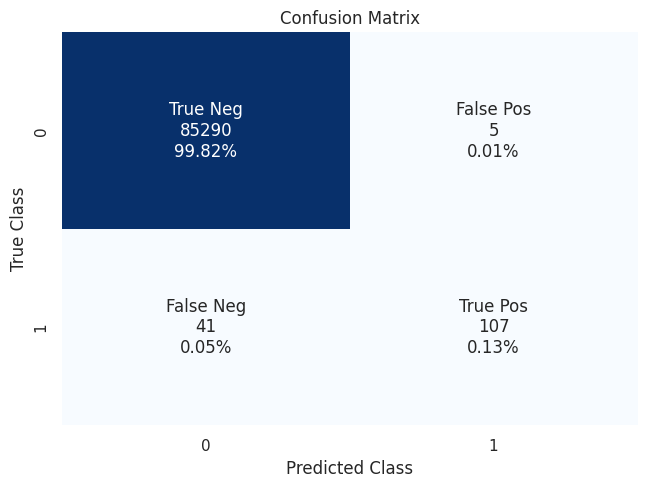

In [31]:
from sklearn.metrics import confusion_matrix
#class_names = ['not_fraud', 'fraud']
matrix = confusion_matrix(y_test.values, y_test_pred_voting)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Create heatmap
sns.heatmap(matrix,cbar=None, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

## Acurácia

A Acurácia é uma métrica que indica a proporção de previsões corretas feitas pelo modelo em relação ao total de previsões

\begin{equation}
\text{Acurácia} = \frac{\text{Número de Previsões Corretas}}{\text{Número Total de Previsões}}
\end{equation}



## Sensibilidade

 A sensibilidade do modelo, também conhecida como taxa de verdadeiro positivo (True Positive Rate), é uma métrica utilizada em modelos de classificação para avaliar o desempenho do modelo. Esta métrica indica a capacidade do modelo de identificar corretamente as ocorrências de uma classe positiva (por exemplo, casos de uma doença, fraudes, etc.).

\begin{equation}
\text{Sensibilidade} = \frac{\text{Verdadeiros Positivos (TP)}}{\text{Verdadeiros Positivos (TP)} + \text{Falsos Negativos (FN)}}
\end{equation}

- Verdadeiros Positivos (TP): Casos onde o modelo previu corretamente a classe positiva.

- Falsos Negativos (FN): Casos onde o modelo previu incorretamente a classe negativa, ou seja, deixou de identificar uma ocorrência positiva.





## Precisão

A precisão do modelo é particularmente importante em aplicações onde os falsos positivos têm um custo elevado, como na detecção de fraudes, diagnósticos médicos ou filtros de spam. No entanto, aumentar a precisão pode diminuir a sensibilidade e vice-versa.

\begin{equation}
\text{Precisão} = \frac{\text{Verdadeiros Positivos (TP)}}{\text{Verdadeiros Positivos (TP)} + \text{Falsos Positivos (FP)}}
\end{equation}

- Verdadeiros Positivos (TP): Casos onde o modelo previu corretamente a classe positiva.

- Falsos Positivos (FP): Casos onde o modelo previu a classe positiva incorretamente (ou seja, a previsão foi positiva, mas a instância era realmente negativa).

## F1 Score

O F1 Score é a média harmônica entre a precisão e a sensibilidade, é utilizada onde há um desequilíbrio de classes, ou seja, quando uma classe é muito mais frequente do que outra. Assim,  **para valores próximo a 1**, tem-se o melhor desempenho possível.

\begin{equation}
F1 = 2 \cdot \frac{\text{Precisão} \cdot \text{Sensibilidade}}{\text{Precisão} + \text{Sensibilidade}}
\end{equation}



# Log-Loss (Logarithmic Loss):

Log-Loss mede a precisão das probabilidades previstas por um modelo de classificação. Uma perda logarítmica baixa indica que o modelo faz previsões confiantes e precisas.


In [30]:
from sklearn.metrics import log_loss
logloss = log_loss(y_test.values, y_test_pred_voting)
print(f'Log-Loss: {logloss:.2f}')


Log-Loss: 0.02


Um valor de 0,02 é excelente em muitos contextos, mas deve ser comparado com outras métricas, como acurácia, AUC, F1-Score, para uma visão completa do desempenho do modelo.

Em resumo, um Log-Loss de 0,02 sugere que o modelo é altamente preciso e confiável, fazendo previsões com grande confiança na maioria das instâncias.